# Sentiment Analysis Demo

#### Objectives:

1. Learn where to get Twitter data related to COVID-19
2. Learn about this dataset and how to "hydrate" its contents to obtain usable tweet data
3. Learn some basic data manipulation tools in pandas
4. Learn how to process the text contents of a tweet into a form that we can use for sentiment analysis 
5. See how to do some basic exploratory data analysis for text data with WordCloud
6. Learn how to do a basic sentiment analysis with TextBlob

In [1]:
# imports (most of them)
import re
import nltk  
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt  

## I. Getting the data

We'll use a dataset of tweets compiled by a number of researchers. They've been streaming tweets since 3/22 and filtering for all tweets related to COVID-19 in some way. They've been updating this dataset every two days since March, and will continue to do so. You can read more about the details of this dataset at this link: https://arxiv.org/pdf/2004.03688.pdf

The data is located at this repository: https://github.com/thepanacealab/covid19_twitter/tree/master/dailies

The big file that contains the ~400 million tweets in total since 3/22 is not located at this repository location (github doesn't like super large files). This repository contains only files of daily tweet updates. If you want to access the big composite tweet file, there's a link in the arxiv article that will take you to a location where this file is available (beware, it's enormous). 

**Important note:** the researchers who compiled this data thought it wise to split the data into two types: 

1. a "clean" set
2. and an unclean set

The unclean dataset includes unique tweets and all retweets, whereas the clean dataset filters out the retweets and contains only the unique tweets. There's all sorts of interesting things we might do with the retweets, but for this demo, we'll use only the "clean" set. 

In particular we'll use the tweets from the most recent update, 6/22. After downloading and unzipping the file, you get a .tsv file ("tab separated value," in contrast to .csv). This is what it looks like: 

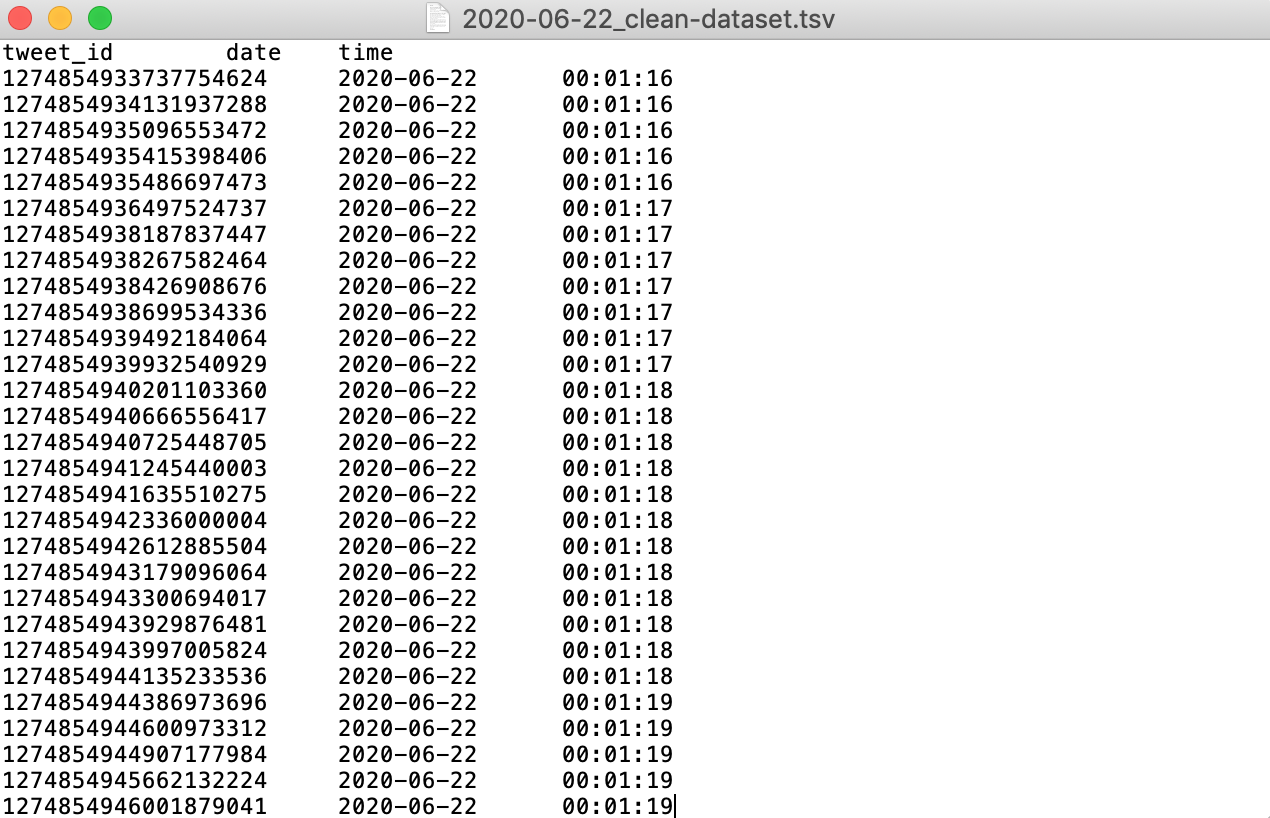

The first column labeled "tweet_id" is where all our data is going to come from. But first, we have to take these tweet id's and "hydrate" them to retrieve the data they contain. 

## II. Hydration and data manipulation

Luckily, somebody build a nice tool to accomplish this task. Check it out: https://github.com/DocNow/hydrator/releases

After downloading Hydrator, you'll want to make sure you have a Twitter account. Hydrator will ask you to link to your Twitter account. The app is pretty simple to use, with one caveat: *Hydrator only takes csv's, and that csv must contain nothing else but the tweet ids.* 

**Note:** While you're running Hydrator, you might notice something like this: 

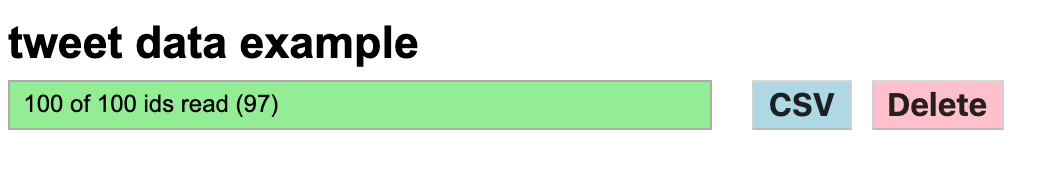

Hydrator is saying that it's read 100 of 100 ids, followed by (97). This means that Hydrator's read all 100 ids, but only 97 of them are actually hydrated. This is because 3 tweets to which those id's refer have been deleted or the account associated with them has been deleted/suspended.


Let's take a look at our .tsv with pandas. 

In [2]:
# load the tsv
tweet_ids = pd.read_csv('/Users/alexnegron/Downloads/2020-06-22_clean-dataset.tsv', sep='\t')

In [3]:
# take a peek
tweet_ids.head()

,tweet_id,date,time
0,1274854933737754624,2020-06-22,00:01:16
1,1274854934131937288,2020-06-22,00:01:16
2,1274854935096553472,2020-06-22,00:01:16
3,1274854935415398406,2020-06-22,00:01:16
4,1274854935486697473,2020-06-22,00:01:16


Remember that Hydrator doesn't want anything else besides tweet id's. That means we have to drop the "date" and "time" columns. We can do that like this: 

In [4]:
tweet_ids = tweet_ids.drop(columns=['date','time'])

In [5]:
tweet_ids.head()

,tweet_id
0,1274854933737754624
1,1274854934131937288
2,1274854935096553472
3,1274854935415398406
4,1274854935486697473


This file contains about 780,000 tweet ids. Due to Twitter's rate limit, this file takes some time to hydrate. For the sake of this demo, we'll only look at the first 100 tweets.

In [6]:
tweet_ids = tweet_ids[:100]
tweet_ids.head(100)

,tweet_id
0,1274854933737754624
1,1274854934131937288
2,1274854935096553472
3,1274854935415398406
4,1274854935486697473
...,...
95,1274854999722319874
96,1274854999936380928
97,1274855000812986369
98,1274855001052057600


Next, we want to export this data as a csv. 

**Important:** if we try to make this a csv and then feed it to Hydrator, we'll get an error. We have to specify that we don't want the header (names of columns, which in this case is just "tweet_id"), and we don't want the column of indices. 

In [7]:
tweet_ids.to_csv('tweet_data_example.csv', header=False, columns=['tweet_id'], index=False)

Now let's look at this hydrated file. 

In [91]:
df = pd.read_csv('/Users/alexnegron/tweet_data_example.csv')

In [92]:
df.head(10)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified
0,NaN,Mon Jun 22 00:01:23 +0000 2020,NaN,NaN,https://twitter.com/FoxNews/status/12747731837...,0,1274854963253055488,NaN,NaN,NaN,...,1,235,0,"Tennessee, USA",Jk adcock,adcock_jk,678,NaN,NaN,False
1,NaN,Mon Jun 22 00:01:18 +0000 2020,NaN,NaN,https://www.clarin.com/sociedad/coronavirus-ar...,1,1274854940725448705,NaN,NaN,NaN,...,1106,33,3,"Chicago, IL",🅒🅞🅡🅐,dogsfdmk,4800,NaN,NaN,False
2,NaN,Mon Jun 22 00:01:30 +0000 2020,NaN,NaN,NaN,1,1274854994106294272,mpbresson,1.274764e+18,3.574291e+08,...,15,31,0,NaN,Amina,Amina53536013,55,NaN,NaN,False
3,NaN,Mon Jun 22 00:01:16 +0000 2020,internacional noticia news tagbusiness,NaN,https://bit.ly/2Yn4m9T,0,1274854934131937288,NaN,NaN,NaN,...,252,913,16,"Caracas, Venezuela",Tu Asesor Global,tuasesorglobal,84959,NaN,http://www.tuasesorglobal.com,False
4,NaN,Mon Jun 22 00:01:30 +0000 2020,WeHo HumanRightsSpeakerSeries HumanRights LGBTQI,https://twitter.com/WeHoReads/status/127485499...,NaN,2,1274854991900151811,NaN,NaN,NaN,...,1026,1872,45,"West Hollywood, California",WeHo Reads,WeHoReads,1629,NaN,http://www.weho.org/wehoreads,False
5,NaN,Mon Jun 22 00:01:17 +0000 2020,NaN,NaN,https://twitter.com/being_woman/status/1274689...,3,1274854938187837447,NaN,NaN,NaN,...,1022,1053,29,"On a pale, blue dot.",Scott Wahlstrom,scottwahlstrom,4144,NaN,https://www.sspec.org/,False
6,NaN,Mon Jun 22 00:01:24 +0000 2020,FlexibilizaciónEnFamilia,https://twitter.com/VTVcanal8/status/127477156...,https://www.vtv.gob.ve/rusia-recuperados-ultim...,0,1274854966235201536,NaN,NaN,NaN,...,22,46,0,NaN,TuiteroActivo,ActivoTuitero,7571,NaN,NaN,False
7,NaN,Mon Jun 22 00:01:20 +0000 2020,NaN,NaN,https://healthandmedical.saltysardonic.com/ore...,0,1274854948388212737,NaN,NaN,NaN,...,161,34,9,New Delhi,Baljeet Singh,je3Tr0ck,7557,NaN,http://www.saltysardonic.com,False
8,NaN,Mon Jun 22 00:01:27 +0000 2020,NaN,NaN,https://twitter.com/DrEricDing/status/12748162...,14,1274854979904258048,BeatrizGMuller,1.274854e+18,9.942663e+17,...,94,468,0,NaN,Super Beto,Vamosdenuevo2,1056,NaN,NaN,False
9,NaN,Mon Jun 22 00:01:29 +0000 2020,LecturaUrbana,NaN,http://urbanopuebla.com.mx/sociedad/noticia/43...,1,1274854989727481858,NaN,NaN,NaN,...,2999,996,21,México,URBANO,urbano_noticias,34520,NaN,NaN,False


In [93]:
# list of all the types of metadata we get about each tweet: 
list(df)

['coordinates',
 'created_at',
 'hashtags',
 'media',
 'urls',
 'favorite_count',
 'id',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'lang',
 'place',
 'possibly_sensitive',
 'retweet_count',
 'reweet_id',
 'retweet_screen_name',
 'source',
 'text',
 'tweet_url',
 'user_created_at',
 'user_screen_name',
 'user_default_profile_image',
 'user_description',
 'user_favourites_count',
 'user_followers_count',
 'user_friends_count',
 'user_listed_count',
 'user_location',
 'user_name',
 'user_screen_name.1',
 'user_statuses_count',
 'user_time_zone',
 'user_urls',
 'user_verified']

Most of this data we don't care about, but some of it is pretty ineteresting. For now, we only care about the actual text of a tweet. Also, we'll want to only grab English tweets. 

In [94]:
df = df.drop(columns=['coordinates',
 'created_at',
 'hashtags',
 'media',
 'urls',
 'favorite_count',
 'id',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'place',
 'possibly_sensitive',
 'retweet_count',
 'reweet_id', # CAUTION! Hydrator authors mispell this
 'retweet_screen_name',
 'source',
 'tweet_url',
 'user_created_at',
 'user_screen_name',
 'user_default_profile_image',
 'user_description',
 'user_favourites_count',
 'user_followers_count',
 'user_friends_count',
 'user_listed_count',
 'user_name',
 'user_screen_name.1',
 'user_statuses_count',
 'user_time_zone',
 'user_urls',
 'user_verified'])

df.head(10)

,lang,text,user_location
0,en,"What is your problem Chris, you are to hard on...","Tennessee, USA"
1,es,Coronavirus en Argentina: informan 19 muertes ...,"Chicago, IL"
2,fr,"@mpbresson Svp aidez mon père âgé de 82 ans, h...",NaN
3,es,Balance AFP: 465.300 fallecidos y cerca de 9 m...,"Caracas, Venezuela"
4,en,"On Wednesday, June 24 at 6:00 PM, join the Cit...","West Hollywood, California"
5,en,This is worth spreading around. Thanks @being_...,"On a pale, blue dot."
6,es,Covid-19 | En Rusia fueron dadas de alta 5.119...,NaN
7,en,"Oregon reports 190 new coronavirus cases, 1 ne...",New Delhi
8,es,@BeatrizGMuller México está de la chingada gra...,NaN
9,es,#LecturaUrbana\n\nHoy en DESDE EL DIVÁN de @Ga...,México


Note that some users actually have their city location in their profile, which gets recorded with their tweet. So, we can potentially grab tweets from Chicago (in this case, the tweet from Chicago is in Spanish, so we will remove it anyways).

In [95]:
df = df.loc[df['lang']=='en'] # filter out the non-English tweets
df = df.drop(columns=['lang', 'user_location'])
df.head(10)

,text
0,"What is your problem Chris, you are to hard on..."
4,"On Wednesday, June 24 at 6:00 PM, join the Cit..."
5,This is worth spreading around. Thanks @being_...
7,"Oregon reports 190 new coronavirus cases, 1 ne..."
11,the fact that employees everywhere around the ...
13,Hopkins doctor counters Trump claim that coron...
14,"@JoeABCNews \nI blame morrison, coalition (fed..."
15,If a retailer demands you pay fees related to ...
19,goddamit kids . we have to do better . Don't k...
20,Banks have grown by $2 trillion in deposits si...


In [96]:
df = df.reset_index(drop=True) # reset row indices

In [97]:
df.head(10)

,text
0,"What is your problem Chris, you are to hard on..."
1,"On Wednesday, June 24 at 6:00 PM, join the Cit..."
2,This is worth spreading around. Thanks @being_...
3,"Oregon reports 190 new coronavirus cases, 1 ne..."
4,the fact that employees everywhere around the ...
5,Hopkins doctor counters Trump claim that coron...
6,"@JoeABCNews \nI blame morrison, coalition (fed..."
7,If a retailer demands you pay fees related to ...
8,goddamit kids . we have to do better . Don't k...
9,Banks have grown by $2 trillion in deposits si...


## III. Text processing

Text is highly unstructured data. As you can see above, there's a lot of numbers, symbols, and all sorts of stuff in the text that we don't want to be analyzing when we run our sentiment analysis, so we have to remove all of that first. There are four steps to processing the text contents of a tweet: 

1. Remove twitter handles marked with @ symbol and URL links
2. Remove punctuations, numbers, and special characters
3. Most of the small words/stop words do not add sentiment value, so we want to remove those too
4. "Lemmatization" 

### 1. Removing @ handles and URL links

First, we'll define a function that will be handy in removing certain textual patterns. 

In [98]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r: 
        input_txt = re.sub(i, '', input_txt)
    return input_txt

The next cell creates a new column called "tidy_tweet" and removes all the @ references, and the cell after removes the URL links.

In [99]:
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")

In [100]:
df['tidy_tweet'] = df['tidy_tweet'].str.replace(r"http\S+", "")

In [101]:
df.head(10)

,text,tidy_tweet
0,"What is your problem Chris, you are to hard on...","What is your problem Chris, you are to hard on..."
1,"On Wednesday, June 24 at 6:00 PM, join the Cit...","On Wednesday, June 24 at 6:00 PM, join the Cit..."
2,This is worth spreading around. Thanks @being_...,This is worth spreading around. Thanks for th...
3,"Oregon reports 190 new coronavirus cases, 1 ne...","Oregon reports 190 new coronavirus cases, 1 ne..."
4,the fact that employees everywhere around the ...,the fact that employees everywhere around the ...
5,Hopkins doctor counters Trump claim that coron...,Hopkins doctor counters Trump claim that coron...
6,"@JoeABCNews \nI blame morrison, coalition (fed...","\nI blame morrison, coalition (federal &amp; ..."
7,If a retailer demands you pay fees related to ...,If a retailer demands you pay fees related to ...
8,goddamit kids . we have to do better . Don't k...,goddamit kids . we have to do better . Don't k...
9,Banks have grown by $2 trillion in deposits si...,Banks have grown by $2 trillion in deposits si...


### 2. Removing punctuation, numbers, and special characters

In [102]:
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [103]:
df[:20]

,text,tidy_tweet
0,"What is your problem Chris, you are to hard on...",What is your problem Chris you are to hard on...
1,"On Wednesday, June 24 at 6:00 PM, join the Cit...",On Wednesday June at PM join the Cit...
2,This is worth spreading around. Thanks @being_...,This is worth spreading around Thanks for th...
3,"Oregon reports 190 new coronavirus cases, 1 ne...",Oregon reports new coronavirus cases ne...
4,the fact that employees everywhere around the ...,the fact that employees everywhere around the ...
5,Hopkins doctor counters Trump claim that coron...,Hopkins doctor counters Trump claim that coron...
6,"@JoeABCNews \nI blame morrison, coalition (fed...",I blame morrison coalition federal amp s...
7,If a retailer demands you pay fees related to ...,If a retailer demands you pay fees related to ...
8,goddamit kids . we have to do better . Don't k...,goddamit kids we have to do better Don t k...
9,Banks have grown by $2 trillion in deposits si...,Banks have grown by trillion in deposits si...


### 3. Removing short words

We remove words having string length $\leq 3$. This may not be the best way to do this for a few reasons. In particular, words like "too" will be dropped which may be important for textual sentiment. For now, we'll do this anyways. 

In [104]:
df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x : ' '.join([w for w in x.split() if len(w) > 3]))

In [105]:
df[:20]

,text,tidy_tweet
0,"What is your problem Chris, you are to hard on...",What your problem Chris hard Mercedes soft Biden
1,"On Wednesday, June 24 at 6:00 PM, join the Cit...",Wednesday June join City West Hollywood OutRig...
2,This is worth spreading around. Thanks @being_...,This worth spreading around Thanks nice contex...
3,"Oregon reports 190 new coronavirus cases, 1 ne...",Oregon reports coronavirus cases death Multnom...
4,the fact that employees everywhere around the ...,fact that employees everywhere around world fr...
5,Hopkins doctor counters Trump claim that coron...,Hopkins doctor counters Trump claim that coron...
6,"@JoeABCNews \nI blame morrison, coalition (fed...",blame morrison coalition federal state right w...
7,If a retailer demands you pay fees related to ...,retailer demands fees related #COVID shipping ...
8,goddamit kids . we have to do better . Don't k...,goddamit kids have better kill Nana cLovis you...
9,Banks have grown by $2 trillion in deposits si...,Banks have grown trillion deposits since coron...


### 4. Lemmatization

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. This is common practice in NLP and has advantages when we get to the analysis stage. Similar to lemmatization is a process called "stemming." Lemmatization is preffered over stemming because lemmatization actually does a full morphological analysis of the words; that is, it links words with similar meaning to one word.  

Examples of lemmatization: 
- rocks : rock
- corpora : corpus
- better : good

To lemmatize a tweet, we first have to "tokenize" them. Tokenization is the process of splitting a string of text into tokens of individual words.

In [106]:
# tokenization 
tokenized_tweet = df['tidy_tweet'].apply(lambda x : x.split())
tokenized_tweet.head()

0    [What, your, problem, Chris, hard, Mercedes, s...
1    [Wednesday, June, join, City, West, Hollywood,...
2    [This, worth, spreading, around, Thanks, nice,...
3    [Oregon, reports, coronavirus, cases, death, M...
4    [fact, that, employees, everywhere, around, wo...
Name: tidy_tweet, dtype: object

One major difference from stemming is that lemmatization takes a part of speech paramter `pos`, and if not supplied in the function call, the default is "noun". Here's an example in code.

In [107]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

print("rocks : ", lemmatizer.lemmatize('rocks'))
print("corpora: ", lemmatizer.lemmatize('corpora'))

# argument in pos here is 'a' for 'adjective'
print('better: ', lemmatizer.lemmatize('better', pos='a'))

rocks :  rock
corpora:  corpus
better:  good


Now let's see how to do this on our tweets.

In [108]:
tokenized_tweet = tokenized_tweet.apply(lambda x : [lemmatizer.lemmatize(i) for i in x]) # lemmatization

# stitch the tokenized tweets back together
# nltk has a detokenizer function, but I do it "manually" here
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

df['tidy_tweet'] = tokenized_tweet
df['tidy_tweet'] = df['tidy_tweet'].str.lower() # lowercase <--- important
df[:20]

,text,tidy_tweet
0,"What is your problem Chris, you are to hard on...",what your problem chris hard mercedes soft biden
1,"On Wednesday, June 24 at 6:00 PM, join the Cit...",wednesday june join city west hollywood outrig...
2,This is worth spreading around. Thanks @being_...,this worth spreading around thanks nice contex...
3,"Oregon reports 190 new coronavirus cases, 1 ne...",oregon report coronavirus case death multnomah...
4,the fact that employees everywhere around the ...,fact that employee everywhere around world fro...
5,Hopkins doctor counters Trump claim that coron...,hopkins doctor counter trump claim that corona...
6,"@JoeABCNews \nI blame morrison, coalition (fed...",blame morrison coalition federal state right w...
7,If a retailer demands you pay fees related to ...,retailer demand fee related #covid shipping la...
8,goddamit kids . we have to do better . Don't k...,goddamit kid have better kill nana clovis your...
9,Banks have grown by $2 trillion in deposits si...,banks have grown trillion deposit since corona...


There are tons of different ways to go about cleaning text data, and there are probably things to improve on with how these tweets are cleaned here. 

For ease of use in the future, we'll define here a function `process_tweets` which will take the string path name of a hydrated .csv file and return a dataframe object that holds the cleaned tweet data. Be sure to import all of the function's library dependencies, and be sure to define a `remove_pattern` function as above, or else this will fail.

In [118]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [123]:
def process_tweets(filename):
    df = pd.read_csv(filename) # read the data into a dataframe object
    df = df.drop(columns=['coordinates', # modify this as necessary; currently it only preserves tweet text
     'created_at',
     'hashtags',
     'media',
     'urls',
     'favorite_count',
     'id',
     'in_reply_to_screen_name',
     'in_reply_to_status_id',
     'in_reply_to_user_id',
     'place',
     'possibly_sensitive',
     'retweet_count',
     'reweet_id',
     'retweet_screen_name',
     'source',
     'tweet_url',
     'user_created_at',
     'user_screen_name',
     'user_default_profile_image',
     'user_description',
     'user_favourites_count',
     'user_followers_count',
     'user_friends_count',
     'user_listed_count',
     'user_location',
     'user_name',
     'user_screen_name.1',
     'user_statuses_count',
     'user_time_zone',
     'user_urls',
     'user_verified'])
    
    df = df.loc[df['lang']=='en'] # get English tweets only
    df = df.drop(columns=['lang']) # then drop the lang column
    
    df['tidy_text'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*") # remove @handles
    df['tidy_text'] = df['tidy_text'].str.replace(r"http\S+", "") # remove URLs and media links
    df['tidy_text'] = df['tidy_text'].str.replace("[^a-zA-Z#]", " ") # remove special characters
    df['tidy_text'] = df['tidy_text'].apply(lambda x : ' '.join([w for w in x.split() if len(w) > 3])) # remove short words
    df['tidy_text'] = df['tidy_text'].str.lower() # lowercase 
    
    tokenized_tweet = df['tidy_text'].apply(lambda x : x.split()) # tokenization
    
    lemmatizer = WordNetLemmatizer()
    tokenized_tweet = tokenized_tweet.apply(lambda x : [lemmatizer.lemmatize(i) for i in x]) # lemmatization

    detokenizer = TreebankWordDetokenizer()
    df['tidy_text'] = tokenized_tweet.apply(lambda x : detokenizer.detokenize(x))
    
    df = df.reset_index(drop=True) # reset row indices
    df.drop(columns=['text']) # drop unclean text
    
    return df

Let's test this function out on the larger dataset that contains all of the tweets for 6/22.

In [124]:
tweets = process_tweets('/Users/alexnegron/large_tweet_data_example.csv')

In [126]:
tweets[1000:1020]

,text,tidy_text
1000,@cathmckenna You’re not normal at all. With al...,normal with misinformation disinformation fund...
1001,People wait for hours on #COVID19 #testing lin...,people wait hour #covid #testing line #maryval...
1002,@realDonaldTrump Trump could eat a piece of ro...,trump could piece rotten beef find plus just l...
1003,@naps3 @DrDenaGrayson There has been a study: ...,there been study reading this right sars covid...
1004,“I care so much about my/other’s health that I...,care much about other health that gonna start ...
1005,Nothing like this in the Philippines 😡 https:/...,nothing like this philippine
1006,@tedlieu @WhiteHouse @realDonaldTrump You know...,know when chinese coronavirus didn even help a...
1007,@zerohedge Hope he washed his hands #theRona #...,hope washed hand #therona #covid
1008,Anyone who thinks govt has done an admirable j...,anyone think govt done admirable already enoug...
1009,I had to take non-electronics phone calls for ...,take electronics phone call minute today gotta...


## IV. Exploratory analysis

Some questions for an EDA on tweet data: 
1. What are the most common words? 
2. What are the most common words in the dataset for negative and positive tweets, respectively? 
3. How many hashtags are there in a given tweet? 
4. Which trends are associated with the dataset?
5. Which trends are associated with either of the sentiments? Are they compatible with the sentiments? 

### Visualizing common words with WordCloud

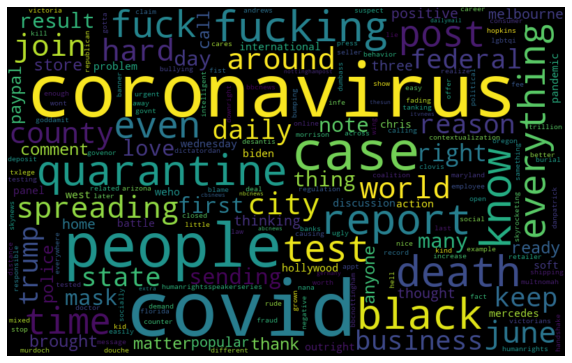

In [109]:
import wordcloud # https://pypi.org/project/wordcloud/
                 # conda installer is easy peasy
    
all_words = ' '.join([text for text in df['tidy_tweet']])

from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Glancing at this, seems we don't see very many positive-looking words. The biggest ones are "coronavirus" and "COVID", which we may interpret as neutral, though we have large negative words like "death" and "fucking," "fuck," and "quarantine." Positive word "love" is quite small, and "nice" is very small (hidden near bottom right).

Here's a word cloud for the entire day 6/22: 

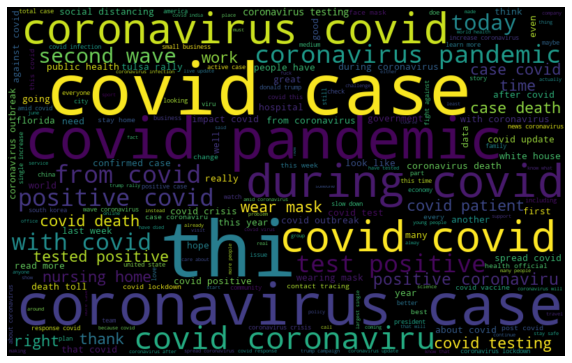

In [127]:
all_words = ' '.join([text for text in tweets['tidy_text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

What does this tell us? Recall that the dataset we have is not every single tweet on 6/22, but only the ones that have something to do with COVID-19. So there's no surprise that almost all of the most used words in the bigger dataset refer to the virus. This is something to be aware of going forward: the frequency distribution of words in the dataset heavily favors words having to do with the virus. Will this influence the way our sentiment analysis algorithms train on this dataset? 

## V. Simple sentiment analysis with TextBlob

Now that the text is processed, we can begin sentiment analysis. We'll use the TextBlob library for this because of how simple it is to use: 

Download: https://anaconda.org/conda-forge/textblob
Documentation: https://textblob.readthedocs.io/en/dev/index.html

It's important to know what's going on under the hood when we call the `sentiment` method in Python. 

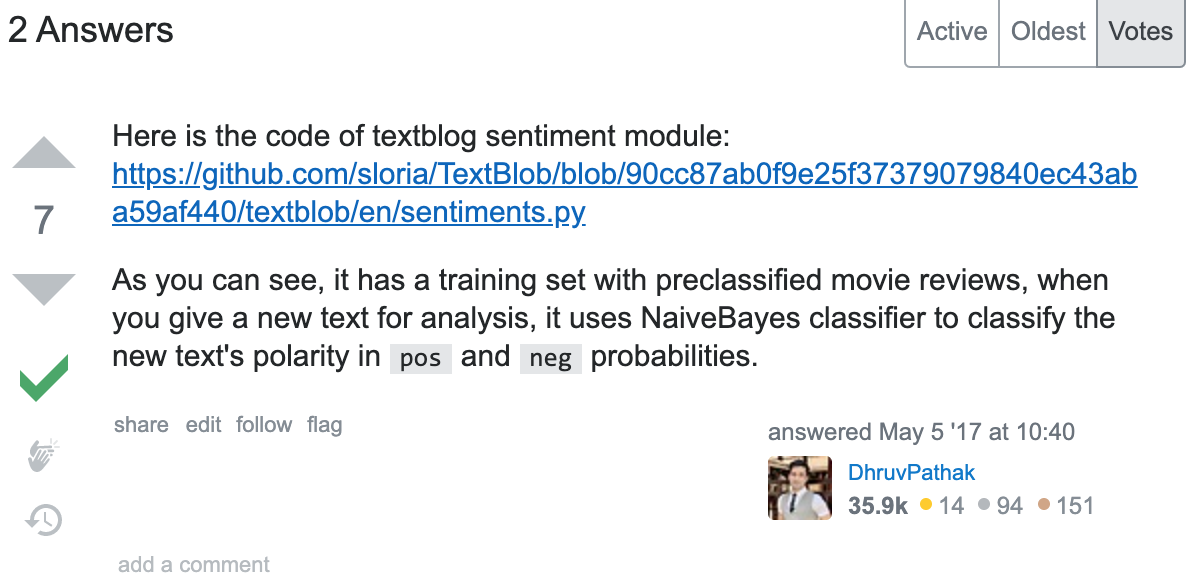

Pros: 
- Easy to use; literally one line of code
- Gives you subjectivity scores in addition to polarity values

Cons:
- Naive Bayes is not the best classification to run here; there are more modern methods
- Training set is a set of movie reviews which are quite different textually than tweets
    - in particular, the length of a movie review is going to be on average much longer than the length of a tweet
    - **Q**: does it matter if the training set's text is of a different nature than the test set's text? Intuitively, I feel the answer is yes, but I really don't know.

To take a more modern approach to sentiment analysis, we have to do the following:
1. Extract word feature vectors via the Word2Vec model. 
2. Select a machine learning algorithm and a test dataset
3. Train the models on the test set and see which performs the best, and tune it

#### Word2Vec feature extraction
The main idea of word embeddings is to redefine the high dimensional word features as low dimensional feature vectors by preserving contextual similarity in the corpus. They can achieve tasks like 

King - man + woman = Queen

In [138]:
from textblob import TextBlob

# df['sentiment'] = df['tidy_tweet'].apply(lambda tweet: TextBlob(tweet).sentiment)
df['polarity'] = df['tidy_tweet'].apply(lambda tweet: TextBlob(tweet).sentiment[0])
df['subjectivity'] = df['tidy_tweet'].apply(lambda tweet: TextBlob(tweet).sentiment[1])

In [140]:
pd.set_option('display.max_colwidth', None) # let's you see more text in the dataframe cells
df[:20]

,tidy_tweet,sentiment,polarity,subjectivity
0,what your problem chris hard mercedes soft biden,"(-0.09583333333333334, 0.4458333333333333)",-0.095833,0.445833
1,wednesday june join city west hollywood outright action international panel discussion world battle covid pandemic #weho #humanrightsspeakerseries #humanrights #lgbtqi,"(0.05, 0.05)",0.050000,0.050000
2,this worth spreading around thanks nice contextualization,"(0.3666666666666667, 0.43333333333333335)",0.366667,0.433333
3,oregon report coronavirus case death multnomah county report record infe,"(0.0, 0.0)",0.000000,0.000000
4,fact that employee everywhere around world from kind business gotta deal with people like this daily should reason enough keep everything closed fuck down,"(-0.009259259259259267, 0.39814814814814814)",-0.009259,0.398148
5,hopkins doctor counter trump claim that coronavirus fading away maryland report,"(0.0, 0.0)",0.000000,0.000000
6,blame morrison coalition federal state right wing murdoch press increase covid case victoria they were bullying andrews open everything even calling #dictatordan they were sending mixed message victorians,"(0.09523809523809523, 0.42857142857142855)",0.095238,0.428571
7,retailer demand fee related #covid shipping law regulation should suspect fraud report seller,"(0.0, 0.4)",0.000000,0.400000
8,goddamit kid have better kill nana clovis your fucking mask social fucking distance fucking douche show little love have republican govnt wont hell they even your burial #txlege #danpatrick,"(-0.1363095238095238, 0.5809523809523809)",-0.136310,0.580952
9,banks have grown trillion deposit since coronavirus first,"(0.25, 0.3333333333333333)",0.250000,0.333333


In [142]:
tweets[100:120]

,text,tidy_text
100,"Indigenous #Business in a Post Covid-19 Economy: Join us for a panel discussion on the impact of #Covid-19 on the #economy and #Indigenous #businesses, with @laurakberry, @_warrenhogan, Gavin Brown @PwC, &amp; Keryn Thompson @CommBank, Today 1pm AEST via Zoom: https://t.co/eYuWOOCWDX",indigenous #business post covid economy join panel discussion impact #covid #economy #indigenous #businesses with gavin brown keryn thompson today aest zoom
101,"You, WHO, Bill Gates, George Soros, Obama, Fauci, Chinese Government, Shadow Government are responsible for damages in Billions! The Business Associations are about to open their claim Vs you spreading the real Virus = FAKE NEWS! Prepare your pockets!!! https://t.co/XMMqdDcl72",bill gate george soros obama fauci chinese government shadow government responsible damage billion business association about open their claim spreading real virus fake news prepare your pocket
102,he looks like a baby mad bc he didn’t get what he wanted awww *victim tears* https://t.co/jQlUTUVyQ8,look like baby didn what wanted awww victim tear
103,"3D printing enthusiasts join fight against coronavirus\nby #Reuters - Apr 3, 2020\n\n2:32\n\nViD https://t.co/NRCQkMpxYK\n\n#CoronaVirus #WuhanVirus #COVID19 #CCPVirus\n\nqt-covid19-vids-190 by #BorderObserver https://t.co/UQzah7TNdO",printing enthusiast join fight against coronavirus #reuters #coronavirus #wuhanvirus #covid #ccpvirus covid vids #borderobserver
104,"@BEVHOWARD40 Scariest words any American will hear “the @whitehouse is preparing for the 2nd wave of #coronavirus.”\n\nAre they keeping it a fucking secret so the “invisible enemy” doesn’t get wind of the plan? We know who they‘re kidding, #WeAreNotAllStupidGOP. #WearAMask #TrumpIsAFuckingMoron",scariest word american will hear preparing wave #coronavirus they keeping fucking secret invisible enemy doesn wind plan know they kidding #wearenotallstupidgop #wearamask #trumpisafuckingmoron
105,"Experts debate whether Connecticut should expect coronavirus second wave: Six months into the virus that has killed nearly 120,000 Americans, left about 40 million unemployed and upended lifestyles across the globe, experts are debating whether… https://t.co/bx4suyatdl https://t.co/zbzwzesXjW",expert debate whether connecticut should expect coronavirus second wave month into virus that killed nearly american left about million unemployed upended lifestyle across globe expert debating whether
106,"like we get it wearing a mask SUCKS but it’s for everyone’s safety &amp; to make enforcing that 10x harder than it already is, is so messed up. https://t.co/GyHxiDja7y",like wearing mask suck everyone safety make enforcing that harder than already messed
107,"@RudyGiuliani @realDonaldTrump Who gives a shit about the plane? Water? Ramp? 122,000 deaths from coronavirus to date. Highest new cases in 12 states. 14.7 unemployment rate. Other than saying it will get better (just like the virus would disappear) what was so great about that speech? https://t.co/4KsRWGzg4V",give shit about plane water ramp death from coronavirus date highest case state unemployment rate other than saying will better just like virus would disappear what great about that speech
108,"Democrats, public health experts decry Trump for saying he asked officials to slow down coronavirus testing#ignorant https://t.co/tDlVQP2bPE",democrat public health expert decry trump saying asked official slow down coronavirus testing#ignorant
109,ON AIR: CHARLIE WILSON / We Entertain. Empower. Educate . Talk to us on 0208 090 2121 HELLO@FANTASTICRADIO.CO.UK #FANTASTICRADIOUK #HOMEOFPOSSIBILITIES #BELIEVEYOURPOSSIBILITIES #STAYHOMESAFELIVES https://t.co/bE4hgti6fx \n Buy song https://t.co/c46NjPvN4J https://t.co/PMOGFfFchf,charlie wilson entertain empower educate talk hello #fantasticradiouk #homeofpossibilities #believeyourpossibilities #stayhomesafelives song
